### Notebook for the cell-cell interaction research of healthy gut with liana package

- **Developed by:** Anna Maguza
- **Institute of Computational Biology - Computational Health Department - Helmholtz Munich**
- 3rd March 2023

### Import required modules

In [1]:
import scanpy as sc
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import liana as li
import anndata as ad

### Set up working environment

In [2]:
%matplotlib inline

In [3]:
sc.settings.verbosity = 3
sc.logging.print_versions()
sc.settings.set_figure_params(dpi = 180, color_map = 'magma_r', dpi_save = 300, vector_friendly = True, format = 'svg')

-----
anndata     0.8.0
scanpy      1.9.3
-----
PIL                         9.4.0
appnope                     0.1.2
asttokens                   NA
backcall                    0.2.0
cffi                        1.15.1
comm                        0.1.2
cycler                      0.10.0
cython_runtime              NA
dateutil                    2.8.2
debugpy                     1.5.1
decorator                   5.1.1
defusedxml                  0.7.1
entrypoints                 0.4
executing                   0.8.3
fontTools                   4.39.3
h5py                        3.8.0
importlib_resources         NA
ipykernel                   6.19.2
ipython_genutils            0.2.0
jedi                        0.18.1
joblib                      1.2.0
jupyter_server              1.23.6
kiwisolver                  1.4.4
liana                       0.1.7
llvmlite                    0.39.1
matplotlib                  3.7.1
matplotlib_inline           0.1.6
mizani                      0.8.1
mpl_

In [4]:
def X_is_raw(adata):
    return np.array_equal(adata.X.sum(axis=0).astype(int), adata.X.sum(axis=0))

### Data Upload

In [5]:
input = '/Users/anna.maguza/Desktop/Data/Processed_datasets/Healthy_reference/Healthy_reference_predicted/SCANVI_predicted_cell_types_15K_stem_cells.h5ad'
output = '/Users/anna.maguza/Desktop/Data/Processed_datasets/Healthy_reference/Healthy_reference_predicted/SCANVI_predicted_cell_types_15K_stem_cells_output.h5ad'

In [6]:
andata = sc.read_h5ad(input)
andata.X

<375293x40144 sparse matrix of type '<class 'numpy.float32'>'
	with 649526885 stored elements in Compressed Sparse Row format>

### Data preprocessing

In [7]:
# Drop fetal and pediatric cells
andata = andata[andata.obs['Diagnosis'] != 'fetal']
andata = andata[andata.obs['Diagnosis'] != 'Pediatric healthy']


In [8]:
andata.obs_keys

<bound method AnnData.obs_keys of View of AnnData object with n_obs × n_vars = 114382 × 40144
    obs: 'UniqueCell_ID', 'Sample_ID', 'CellType', 'Study_name', 'Donor_ID', 'Diagnosis', 'Age', 'Region code', 'Fraction', 'Gender', '10X', 'batch', 'n_genes', 'n_genes_by_counts', 'total_counts_mt', 'doublet_scores', 'predicted_doublets', 'Age_group', 'total_counts_ribo', 'Location', 'n_counts', 'percent_mito', 'percent_ribo', 'Cell States', 'Predicted Cell Labels'>

### Liana Run

In [9]:
# import all individual methods
import liana 
from liana.method import singlecellsignalr, connectome, cellphonedb, natmi, logfc, cellchat, geometric_mean

### Run CellChat

In [10]:
X_is_raw(andata)

True

In [11]:
andata.raw = ad.AnnData(andata.X, andata.obs, andata.var)

In [12]:
#run cellchat
cellchat(andata, groupby='Predicted Cell Labels', expr_prop=0.1, verbose=True)

Using `.raw`!
6056 features of mat are empty, they will be removed.
Make sure that normalized counts are passed!


/Users/anna.maguza/.local/lib/python3.9/site-packages/pandas/core/indexing.py:1667: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.


The following cell identities were excluded: CLC+ Mast cell, Fetal arterial EC, K cells (GIP+), M/X cells (MLN/GHRL+), Progenitor (NEUROG3+), Stromal 2 (CH25H+), Th1
0.04 of entities in the resource are missing from the data.
Generating ligand-receptor stats for 114362 samples and 34088 features


100%|██████████| 1000/1000 [1:02:47<00:00,  3.77s/it]


In [13]:
df = andata.obs['Predicted Cell Labels'].value_counts()

In [14]:
#Write anndata object to file
andata.write('/Users/anna.maguza/Desktop/Data/Processed_datasets/CCI/liana/Adult_all_cells_post-liana_cellChat.h5ad')

In [19]:
andata.uns['liana_res']

,ligand,ligand_complex,ligand_props,ligand_trimean,mat_max,receptor,receptor_complex,receptor_props,receptor_trimean,source,target,lr_probs,cellchat_pvals
0,LGALS1,LGALS1,0.134039,0.000000,24780.0,PTPRC,PTPRC,0.874780,0.000091,Activated CD4 T,Activated CD4 T,0.000000e+00,1.000
1,ADAM10,ADAM10,0.174603,0.000000,24780.0,CD44,CD44,0.682540,0.000040,Activated CD4 T,Activated CD4 T,0.000000e+00,1.000
2,COL6A3,COL6A3,0.165785,0.000000,24780.0,CD44,CD44,0.682540,0.000040,Activated CD4 T,Activated CD4 T,0.000000e+00,1.000
4,MIF,MIF,0.811287,0.000081,24780.0,CD74,CD44_CD74,0.523810,0.000030,Activated CD4 T,Activated CD4 T,4.885608e-09,0.001
5,VIM,VIM,0.835979,0.000131,24780.0,CD44,CD44,0.682540,0.000040,Activated CD4 T,Activated CD4 T,1.058548e-08,0.000
...,...,...,...,...,...,...,...,...,...,...,...,...,...
680670,FSTL1,FSTL1,0.142857,0.000000,24780.0,DIP2A,DIP2A,0.142857,0.000000,venous capillary,venous capillary,0.000000e+00,1.000
680671,BSG,BSG,0.142857,0.000000,24780.0,SLC16A7,SLC16A7,0.142857,0.000000,venous capillary,venous capillary,0.000000e+00,1.000
680672,MUC2,MUC2,0.142857,0.000000,24780.0,AGR2,AGR2,0.142857,0.000000,venous capillary,venous capillary,0.000000e+00,1.000
680673,TGS1,TGS1,0.142857,0.000000,24780.0,RXRA,RXRA,0.142857,0.000000,venous capillary,venous capillary,0.000000e+00,1.000


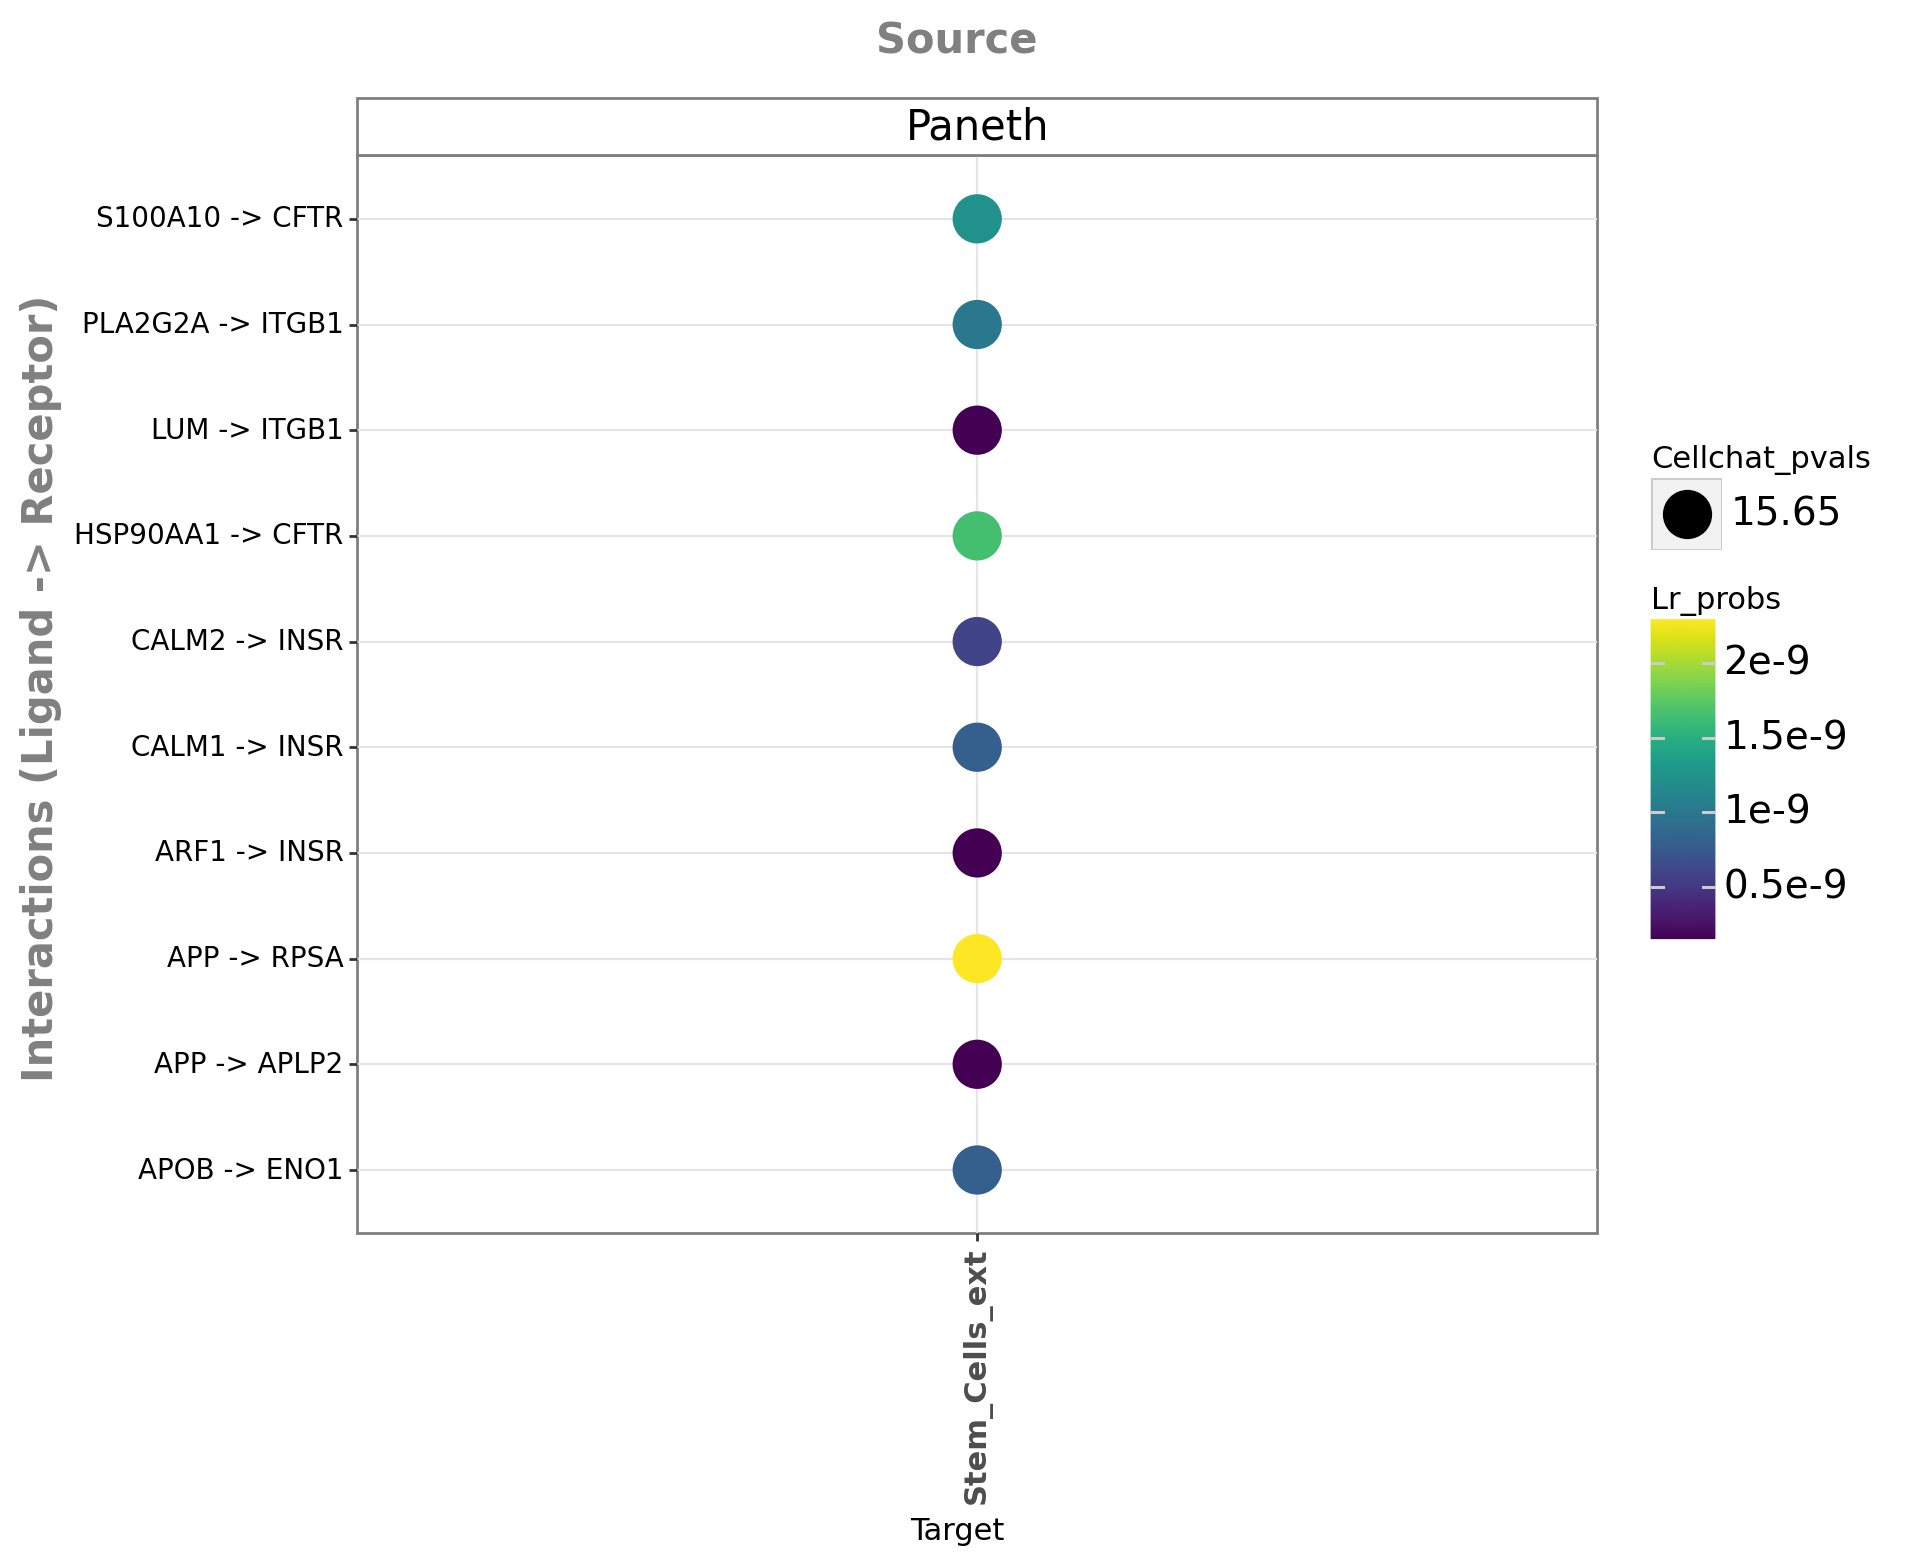

<ggplot: (1252153013)>

In [22]:
li.pl.dotplot(adata = andata, 
              colour='lr_probs',
              size='cellchat_pvals',
              inverse_size=True, # we inverse sign since we want small p-values to have large sizes
              source_labels=['Paneth'],
              target_labels=['Stem_Cells_ext'],
              figure_size=(8, 7),
              # finally, since cpdbv2 suggests using a filter to FPs
              # we filter the pvals column to <= 0.05
              filterby='cellchat_pvals',
              filter_lambda=lambda x: x <= 0.05
             )

### Omnipath

In [23]:
X_is_raw(andata)

True

In [24]:
#run omnipath
natmi(andata, groupby='Predicted Cell Labels', verbose=True)

Using `.raw`!
6056 features of mat are empty, they will be removed.
Make sure that normalized counts are passed!


/Users/anna.maguza/.local/lib/python3.9/site-packages/pandas/core/indexing.py:1667: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.


The following cell identities were excluded: CLC+ Mast cell, Fetal arterial EC, K cells (GIP+), M/X cells (MLN/GHRL+), Progenitor (NEUROG3+), Stromal 2 (CH25H+), Th1
0.04 of entities in the resource are missing from the data.
Generating ligand-receptor stats for 114362 samples and 34088 features


In [25]:
#Write anndata object to file
andata.write('/Users/anna.maguza/Desktop/Data/Processed_datasets/CCI/liana/Adult_all_cells_post-liana_omnipath.h5ad')

In [26]:
andata.uns['liana_res']

,ligand,ligand_complex,ligand_means,ligand_means_sums,ligand_props,receptor,receptor_complex,receptor_means,receptor_means_sums,receptor_props,source,target,expr_prod,spec_weight
0,LGALS1,LGALS1,0.246914,123.919868,0.134039,PTPRC,PTPRC,2.777774,98.580772,0.874780,Activated CD4 T,Activated CD4 T,0.685870,0.000056
1,ADAM10,ADAM10,0.206349,22.520308,0.174603,CD44,CD44,1.493827,44.759979,0.682540,Activated CD4 T,Activated CD4 T,0.308250,0.000306
2,COL6A3,COL6A3,0.201058,40.073917,0.165785,CD44,CD44,1.493827,44.759979,0.682540,Activated CD4 T,Activated CD4 T,0.300346,0.000167
4,MIF,MIF,2.209872,222.872879,0.811287,CD74,CD44_CD74,1.086418,1114.629639,0.523810,Activated CD4 T,Activated CD4 T,2.400846,0.000010
5,VIM,VIM,4.627862,509.382660,0.835979,CD44,CD44,1.493827,44.759979,0.682540,Activated CD4 T,Activated CD4 T,6.913226,0.000303
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
680666,FSTL1,FSTL1,0.285714,21.493290,0.142857,DIP2A,DIP2A,0.142857,12.798408,0.142857,venous capillary,venous capillary,0.040816,0.000148
680667,BSG,BSG,0.142857,75.308334,0.142857,SLC16A7,SLC16A7,0.142857,5.720090,0.142857,venous capillary,venous capillary,0.020408,0.000047
680668,MUC2,MUC2,0.142857,66.824120,0.142857,AGR2,AGR2,0.428571,115.771896,0.142857,venous capillary,venous capillary,0.061224,0.000008
680669,TGS1,TGS1,0.142857,11.163895,0.142857,RXRA,RXRA,0.142857,5.507439,0.142857,venous capillary,venous capillary,0.020408,0.000332


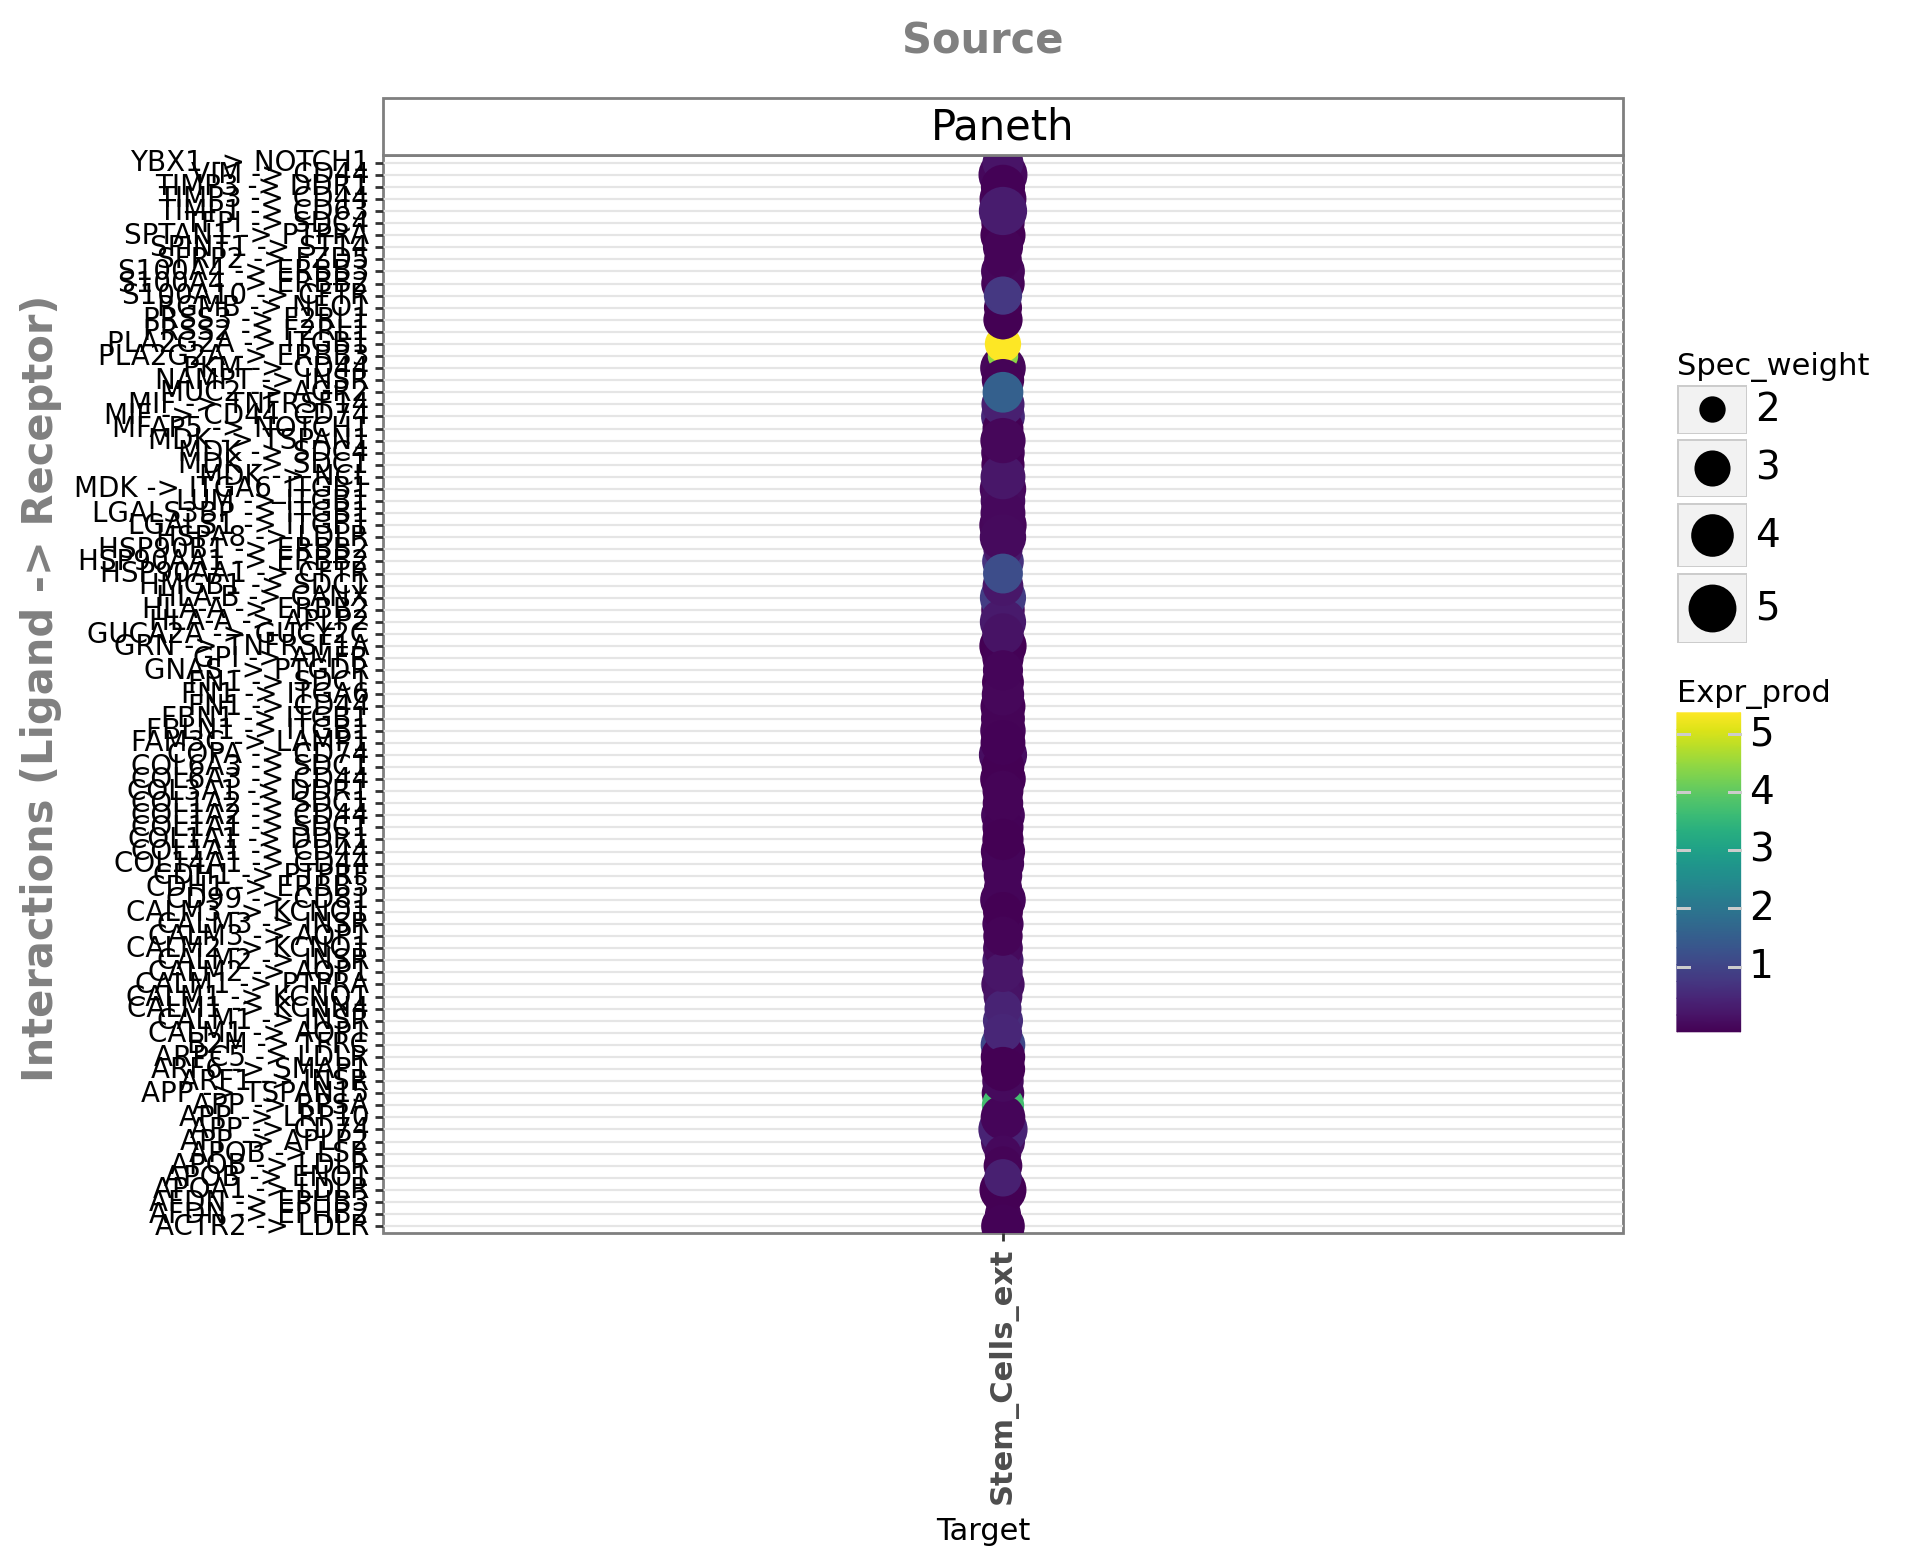

<ggplot: (1013201288)>

In [34]:
li.pl.dotplot(adata = andata, 
              colour='expr_prod',
              size='spec_weight',
              inverse_size=True, # we inverse sign since we want small p-values to have large sizes
              source_labels=['Paneth'],
              target_labels=['Stem_Cells_ext'],
              figure_size=(8, 7)
             )

### Rank Aggregate

In [35]:
X_is_raw(andata)

True

In [36]:
andata.raw = ad.AnnData(andata.X, andata.obs, andata.var)

In [37]:
# Run rank_aggregate
li.mt.rank_aggregate(andata, groupby='Predicted Cell Labels', expr_prop=0.1, verbose=True)

Using `.raw`!
6056 features of mat are empty, they will be removed.
Make sure that normalized counts are passed!


/Users/anna.maguza/.local/lib/python3.9/site-packages/pandas/core/indexing.py:1667: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.


The following cell identities were excluded: CLC+ Mast cell, Fetal arterial EC, K cells (GIP+), M/X cells (MLN/GHRL+), Progenitor (NEUROG3+), Stromal 2 (CH25H+), Th1
0.04 of entities in the resource are missing from the data.
Generating ligand-receptor stats for 114362 samples and 34088 features
... as `zero_center=True`, sparse input is densified and may lead to large memory consumption
Assuming that counts were `natural` log-normalized!


/Users/anna.maguza/miniconda3/envs/liana_env/lib/python3.9/site-packages/liana/method/_liana_pipe.py:422: RuntimeWarning: overflow encountered in power
/Users/anna.maguza/miniconda3/envs/liana_env/lib/python3.9/site-packages/liana/method/_liana_pipe.py:415: RuntimeWarning: invalid value encountered in subtract


Running CellPhoneDB


100%|██████████| 1000/1000 [01:20<00:00, 12.40it/s]


Running Connectome
Running log2FC
Running NATMI
Running SingleCellSignalR
Running CellChat


100%|██████████| 1000/1000 [56:26<00:00,  3.39s/it]


In [38]:
andata.uns['liana_res'].head()

,source,target,ligand_complex,receptor_complex,lr_means,cellphone_pvals,expr_prod,scaled_weight,lr_logfc,spec_weight,lrscore,lr_probs,cellchat_pvals,steady_rank,specificity_rank,magnitude_rank
147562,D cells (SST+),I cells (CCK+),SST,SSTR2,3217.333578,0.0,23580.335635,84.164164,NaN,0.482386,0.998997,0.000077,0.0,NaN,NaN,2.450274e-16
347730,D cells (SST+),N cells (NTS+),SST,SSTR2,3216.000244,0.0,6431.000488,69.682617,NaN,0.131560,0.998082,0.000022,0.0,NaN,NaN,1.960216e-15
179123,D cells (SST+),L cells (PYY+),SST,SSTR2,3215.855083,0.0,4563.936078,68.105997,NaN,0.093365,0.997724,0.000008,0.0,NaN,NaN,3.062820e-14
147561,D cells (SST+),I cells (CCK+),SST,SSTR1,3215.833577,0.0,4287.333787,65.794501,NaN,0.304859,0.997652,0.000018,0.0,NaN,NaN,3.438993e-14
36616,D cells (SST+),BEST4+ epithelial,SST,ADRA2A,3215.890410,0.0,5018.307609,65.295563,NaN,0.321590,0.997829,0.000005,0.0,NaN,NaN,1.504754e-13


In [39]:
#Write anndata object to file
andata.write('/Users/anna.maguza/Desktop/Data/Processed_datasets/CCI/liana/Adult_all_cells_post-liana_aggregate.h5ad')

/Users/anna.maguza/miniconda3/envs/liana_env/lib/python3.9/site-packages/plotnine/layer.py:411: PlotnineWarning: geom_point : Removed 10 rows containing missing values.


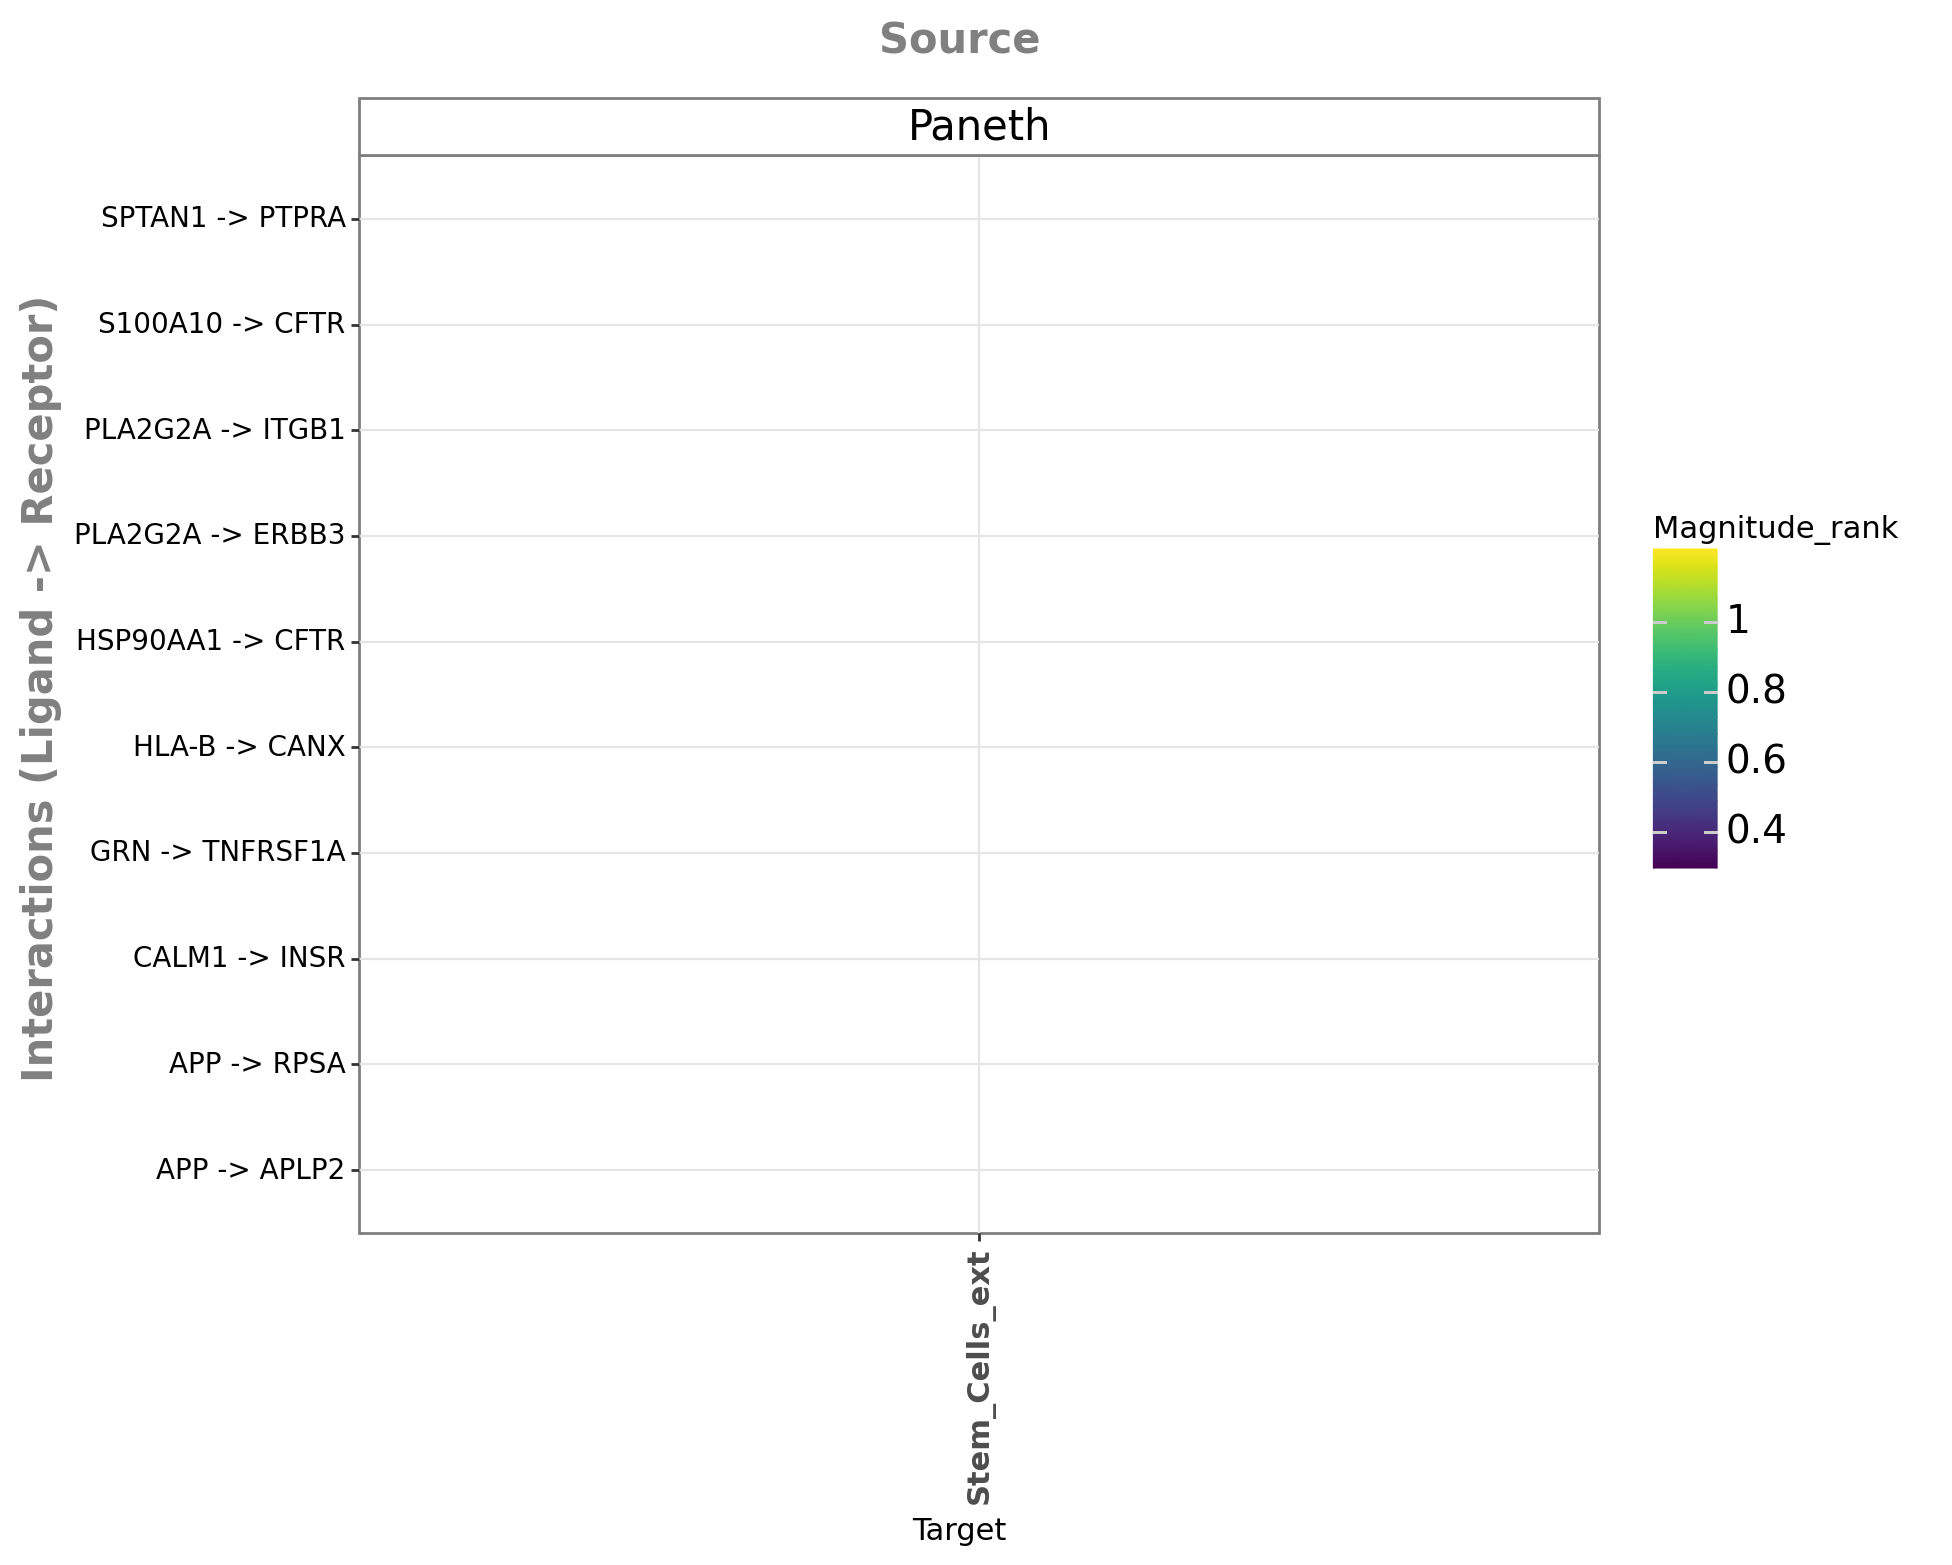

<ggplot: (1013190096)>

In [40]:
li.pl.dotplot(adata = andata,
              colour='magnitude_rank',
              size='specificity_rank',
              inverse_size=True,
              inverse_colour=True,
              source_labels=['Paneth'],
              target_labels=['Stem_Cells_ext'],
              top_n=10,
              orderby='magnitude_rank',
              orderby_ascending=True,
              figure_size=(8, 7)
             )